In [26]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils import data
def prepare_data():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

    root_dir = "./data3/train";
    train_set = datasets.ImageFolder(root = root_dir,
                transform = transforms.ToTensor())

    trainloader = data.DataLoader(train_set, batch_size = 4, shuffle = True)

    root_dir = "./data3/test";

    train_set = datasets.ImageFolder(root = root_dir,
                transform = transforms.ToTensor())


    testloader = data.DataLoader(train_set, batch_size =4, shuffle = True)
    classes = ('Natalie Portman', 'Julia Roberts', 'Neil Patrick Harris'
                    , 'Keifer Sutherland', 'Ben Stiller', 'Anne Hathaway'
                    , 'David Boreanaz', 'Jamie Foxx', 'Sofia Vergara'
                    , 'Elizabeth Banks', 'Jensen Ackles', 'Amy Adams'
                    , 'Kristen Bell', 'Bradley Cooper', 'Emily Deschanel'
                    , 'Zooey Deschanel', 'Jon Hamm', 'Scarlett Johansson'
                    , 'Blake Lively', 'Eva Longoria', 'Amy Poehler'
                    , 'Kristen Stewart', 'Kerry Washington', 'Leighton Meester'
                    , 'Olivia Wilde', 'Zac Efron', 'Miley Cyrus','Jim Parsons')
    return trainloader, testloader, classes
trainloader, testloader, classes = prepare_data()
#
print("train size: " + str(len(trainloader)))
#
print("test size: " + str(len(testloader)))

train size: 2800
test size: 693


torch.Size([4, 3, 250, 250])
Eva Longoria


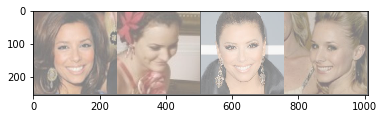

In [27]:
trainloader, testloader, classes = prepare_data()

import matplotlib.pyplot as plt
import numpy as np


# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(1)))

In [28]:
import torch.nn as nn
import torch.nn.functional as F

def prepare_and_init_Net(number_layers_1, number_layers_2, number_layers_3):
    class Net(nn.Module):
        def __init__(self, device):
            super(Net, self).__init__()
            self.conv1 = nn.Conv2d(3, 6, 11)
            self.conv2 = nn.Conv2d(6, 12, 9)
            self.conv3 = nn.Conv2d(12, 24, 7)
            self.conv4 = nn.Conv2d(24, 30, 6)
            self.pool2 = nn.MaxPool2d(2, 2)
            self.conv2_bn_30 = nn.BatchNorm2d(30)
            self.conv2_bn_24 = nn.BatchNorm2d(24)
            self.conv2_bn_12 = nn.BatchNorm2d(12)
            self.conv2_bn_6 = nn.BatchNorm2d(6)
            # self.pool3 = nn.MaxPool2d(3,3)
            self.fc1 = nn.Linear(30 * 10 * 10, 800) 
            self.fc1_bn = nn.BatchNorm1d(800)#coś tu się dzieje, nie jestem pewnien co
            # self.fc2 = nn.Linear(240, 120)
            self.fc3 = nn.Linear(800, 28)

        def forward(self, x):
            # print(x.shape)
            x = self.pool2(F.relu(self.conv2_bn_6(self.conv1(x))))
            # print(x.shape)
            x = self.pool2(F.relu(self.conv2_bn_12(self.conv2(x))))

            x = self.pool2(F.relu(self.conv2_bn_24(self.conv3(x))))
            x = self.pool2(F.relu(self.conv2_bn_30(self.conv4(x))))
            # print(x.shape)
            # print("to tu?")
            x = x.view(-1, 30 * 10 * 10)
            # print(x.shape)
            x = F.relu(self.fc1_bn(self.fc1(x)))
            # print(x.shape)
            # x = F.relu(self.fc2(x))
            # print(x.shape)
            x = self.fc3(x)
            # print(x.shape)
            return x


    net = Net(device='cuda:0')
    return net
# print(net.parameters())

In [29]:
import torch.optim as optim

net = prepare_and_init_Net(6, 12, 24)

def crit_and_opt(learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    return criterion, optimizer

In [30]:
def cuda_init():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    return device
# Assuming that we are on a CUDA machine, this should print a CUDA device:


In [31]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
def accuracy(device, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Accuracy of the network on the 2772 test images: %f %%' % (
        100 * correct / total))
        return 100 * correct / total


In [32]:
def learn(device, trainloader, testloader, optimizer, criterion):
    running_loss_for_optimizer = 0.0
    running_loss = 0.0
    loss_for_optimizer = 1.0
    learning_rate = 0.001
    counter=0
    for epoch in range(15):  # loop over the dataset multiple times


        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            # inputs, labels = data
            inputs, labels = data[0].to(device), data[1].to(device)
            # print(inputs.shape)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            # print(outputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            running_loss_for_optimizer += loss.item()
            if i % 4000 == 3999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 4000))
                running_loss = 0.0
        print("running loss at end of epoch: ", running_loss_for_optimizer/len(trainloader))
        # if(accuracy(device, testloader) > 75):
        #     break
        accuracy(device, testloader)
        if(running_loss_for_optimizer/len(trainloader) < loss_for_optimizer):
            learning_rate /= 2
            loss_for_optimizer /= 2
            criterion, optimizer = crit_and_opt(learning_rate)
            print( "devaluating optimizer, current value: ", loss_for_optimizer)
        running_loss_for_optimizer = 0.0
        running_loss = 0.0


    print('Finished Training')

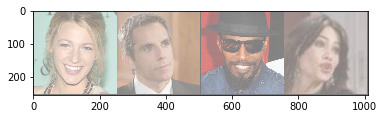

GroundTruth:  Blake Lively Ben Stiller Jamie Foxx Sofia Vergara


In [33]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
trainloader, testloader, classes = prepare_data()
device = cuda_init()
net = prepare_and_init_Net(6, 12, 24)
criterion, optimizer = crit_and_opt(0.001)
learn(device, trainloader, testloader, optimizer, criterion)

running loss at end of epoch:  2.335803617537022
Accuracy of the network on the 2772 test images: 47.979798 %
running loss at end of epoch:  1.5034594903673444
Accuracy of the network on the 2772 test images: 60.209235 %
running loss at end of epoch:  1.1126313289787089
Accuracy of the network on the 2772 test images: 64.935065 %
running loss at end of epoch:  0.8739310096417154
Accuracy of the network on the 2772 test images: 65.764791 %
devaluating optimizer, current value:  0.5
running loss at end of epoch:  0.5929080357509
Accuracy of the network on the 2772 test images: 68.759019 %
running loss at end of epoch:  0.4646177076441901
Accuracy of the network on the 2772 test images: 70.238095 %
devaluating optimizer, current value:  0.25
running loss at end of epoch:  0.35337711295911245
Accuracy of the network on the 2772 test images: 71.176046 %
running loss at end of epoch:  0.3101114279244627
Accuracy of the network on the 2772 test images: 71.248196 %
running loss at end of epoch

In [ ]:
class_correct = list(0. for i in range(28))
class_total = list(0. for i in range(28))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(28):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
PATH = './actors_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
dataiter = iter(testloader)
images, labels = data[0].to(device), data[1].to(device)

# print images
imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Przed przejrzeniem danych
[1,  1000] loss: 3.334
[1,  2000] loss: 3.334
Accuracy of the network on the 2772 test images: 3.860029 %
[2,  1000] loss: 3.281
[2,  2000] loss: 3.048
Accuracy of the network on the 2772 test images: 25.901876 %
[3,  1000] loss: 2.434
[3,  2000] loss: 2.124
Accuracy of the network on the 2772 test images: 47.799423 %
[4,  1000] loss: 1.649
[4,  2000] loss: 1.581
Accuracy of the network on the 2772 test images: 58.874459 %
[5,  1000] loss: 1.285
[5,  2000] loss: 1.246
Accuracy of the network on the 2772 test images: 52.597403 %
[6,  1000] loss: 1.003
[6,  2000] loss: 1.019
Accuracy of the network on the 2772 test images: 61.976912 %
[7,  1000] loss: 0.775
[7,  2000] loss: 0.869
Accuracy of the network on the 2772 test images: 60.714286 %
[8,  1000] loss: 0.709
[8,  2000] loss: 0.723
Accuracy of the network on the 2772 test images: 57.359307 %
[9,  1000] loss: 0.592
[9,  2000] loss: 0.657
Accuracy of the network on the 2772 test images: 62.229437 %
[10,  1000] loss: 0.607
[10,  2000] loss: 0.617


Po przejrzeniu danych pierwszym:

[1,  1000] loss: 3.334
[1,  2000] loss: 3.332
Accuracy of the network on the 2772 test images: 4.004329 %
[2,  1000] loss: 3.199
[2,  2000] loss: 2.879
Accuracy of the network on the 2772 test images: 31.854257 %
[3,  1000] loss: 2.285
[3,  2000] loss: 2.050
Accuracy of the network on the 2772 test images: 47.005772 %
[4,  1000] loss: 1.692
[4,  2000] loss: 1.549
Accuracy of the network on the 2772 test images: 58.549784 %
[5,  1000] loss: 1.263
[5,  2000] loss: 1.251
Accuracy of the network on the 2772 test images: 61.219336 %
[6,  1000] loss: 1.066
[6,  2000] loss: 1.031
Accuracy of the network on the 2772 test images: 60.966811 %
[7,  1000] loss: 0.901
[7,  2000] loss: 0.931
Accuracy of the network on the 2772 test images: 61.868687 %
[8,  1000] loss: 0.782
[8,  2000] loss: 0.769
Accuracy of the network on the 2772 test images: 63.419913 %
[9,  1000] loss: 0.583
[9,  2000] loss: 0.785
Accuracy of the network on the 2772 test images: 63.059163 %
[10,  1000] loss: 0.677
[10,  2000] loss: 0.668
Accuracy of the network on the 2772 test images: 61.147186 %

Po drugim przejrzeniu:

[1,  1000] loss: 3.333
[1,  2000] loss: 3.333
Accuracy of the network on the 2772 test images: 8.297258 %
[2,  1000] loss: 3.204
[2,  2000] loss: 2.940
Accuracy of the network on the 2772 test images: 26.298701 %
[3,  1000] loss: 2.363
[3,  2000] loss: 2.119
Accuracy of the network on the 2772 test images: 43.398268 %
[4,  1000] loss: 1.743
[4,  2000] loss: 1.643
Accuracy of the network on the 2772 test images: 51.659452 %
[5,  1000] loss: 1.242
[5,  2000] loss: 1.305
Accuracy of the network on the 2772 test images: 60.461760 %
[6,  1000] loss: 1.026
[6,  2000] loss: 1.091
Accuracy of the network on the 2772 test images: 61.255411 %
[7,  1000] loss: 0.806
[7,  2000] loss: 0.907
Accuracy of the network on the 2772 test images: 63.311688 %
[8,  1000] loss: 0.722
[8,  2000] loss: 0.755
Accuracy of the network on the 2772 test images: 57.792208 %
[9,  1000] loss: 0.685
[9,  2000] loss: 0.655
Accuracy of the network on the 2772 test images: 63.492063 %
[10,  1000] loss: 0.547
[10,  2000] loss: 0.628
Accuracy of the network on the 2772 test images: 64.790765 %
Finished Training

learning rate = 0,0004
[1,  1000] loss: 3.334
[1,  2000] loss: 3.332
Accuracy of the network on the 2772 test images: 4.256854 %
[2,  1000] loss: 3.330
[2,  2000] loss: 3.300
Accuracy of the network on the 2772 test images: 11.616162 %
[3,  1000] loss: 2.952
[3,  2000] loss: 2.694
Accuracy of the network on the 2772 test images: 26.984127 %
[4,  1000] loss: 2.215
[4,  2000] loss: 1.962
Accuracy of the network on the 2772 test images: 43.867244 %
[5,  1000] loss: 1.551
[5,  2000] loss: 1.487
Accuracy of the network on the 2772 test images: 59.848485 %
[6,  1000] loss: 1.160
[6,  2000] loss: 1.122
Accuracy of the network on the 2772 test images: 60.028860 %
[7,  1000] loss: 0.861
[7,  2000] loss: 0.869
Accuracy of the network on the 2772 test images: 65.909091 %
[8,  1000] loss: 0.601
[8,  2000] loss: 0.659
Accuracy of the network on the 2772 test images: 63.816739 %
[9,  1000] loss: 0.415
[9,  2000] loss: 0.469
Accuracy of the network on the 2772 test images: 66.883117 %
[10,  1000] loss: 0.323
[10,  2000] loss: 0.393
Accuracy of the network on the 2772 test images: 66.089466 %
Finished Training

learning rate lowering

[1,  1000] loss: 3.333
[1,  2000] loss: 3.334
running loss at end of epoch:  3.3338789576752035
Accuracy of the network on the 2772 test images: 3.427128 %
[2,  1000] loss: 3.333
[2,  2000] loss: 3.333
running loss at end of epoch:  3.3330981483163518
Accuracy of the network on the 2772 test images: 4.942280 %
[3,  1000] loss: 3.324
[3,  2000] loss: 3.137
running loss at end of epoch:  3.161060254736402
Accuracy of the network on the 2772 test images: 17.712843 %
[4,  1000] loss: 2.546
[4,  2000] loss: 2.213
running loss at end of epoch:  2.3071322710526725
Accuracy of the network on the 2772 test images: 41.233766 %
[5,  1000] loss: 1.716
[5,  2000] loss: 1.597
running loss at end of epoch:  1.6163126437846083
Accuracy of the network on the 2772 test images: 52.128427 %
[6,  1000] loss: 1.216
[6,  2000] loss: 1.213
running loss at end of epoch:  1.2100376825568238
Accuracy of the network on the 2772 test images: 61.363636 %
[7,  1000] loss: 0.881
[7,  2000] loss: 0.929
running loss at end of epoch:  0.9269742024898918
Accuracy of the network on the 2772 test images: 61.580087 %
devaluating optimizer, current value:  0.5
[8,  1000] loss: 0.412
[8,  2000] loss: 0.417
running loss at end of epoch:  0.4169385712114632
Accuracy of the network on the 2772 test images: 70.057720 %
devaluating optimizer, current value:  0.25
[9,  1000] loss: 0.150
[9,  2000] loss: 0.117
running loss at end of epoch:  0.1349121487934086
Accuracy of the network on the 2772 test images: 70.382395 %
devaluating optimizer, current value:  0.125
[10,  1000] loss: 0.037
[10,  2000] loss: 0.034
running loss at end of epoch:  0.03691134512692191
Accuracy of the network on the 2772 test images: 71.356421 %
devaluating optimizer, current value:  0.0625
[11,  1000] loss: 0.012
[11,  2000] loss: 0.012
running loss at end of epoch:  0.011455203110269256
Accuracy of the network on the 2772 test images: 71.861472 %
devaluating optimizer, current value:  0.03125
[12,  1000] loss: 0.007
[12,  2000] loss: 0.008
running loss at end of epoch:  0.007031942859578006
Accuracy of the network on the 2772 test images: 71.933622 %
devaluating optimizer, current value:  0.015625
[13,  1000] loss: 0.005
[13,  2000] loss: 0.007
running loss at end of epoch:  0.005828184709591786
Accuracy of the network on the 2772 test images: 71.897547 %
devaluating optimizer, current value:  0.0078125
[14,  1000] loss: 0.007
[14,  2000] loss: 0.004
running loss at end of epoch:  0.0053725935527868494
Accuracy of the network on the 2772 test images: 71.969697 %
devaluating optimizer, current value:  0.00390625
[15,  1000] loss: 0.005
[15,  2000] loss: 0.005
running loss at end of epoch:  0.00516883477039267
Accuracy of the network on the 2772 test images: 71.969697 %
Finished Training

druga próba
running loss at end of epoch:  3.3339393543875815
Accuracy of the network on the 2772 test images: 3.571429 %
running loss at end of epoch:  3.2924819636121
Accuracy of the network on the 2772 test images: 14.826840 %
running loss at end of epoch:  2.649108797177922
Accuracy of the network on the 2772 test images: 34.018759 %
running loss at end of epoch:  1.9592065367468916
Accuracy of the network on the 2772 test images: 49.494949 %
running loss at end of epoch:  1.5433724770720223
Accuracy of the network on the 2772 test images: 54.365079 %
running loss at end of epoch:  1.2747982933040345
Accuracy of the network on the 2772 test images: 59.812410 %
running loss at end of epoch:  1.1017621994359292
Accuracy of the network on the 2772 test images: 58.189033 %
running loss at end of epoch:  0.9837924131888572
Accuracy of the network on the 2772 test images: 61.399711 %
devaluating optimizer, current value:  0.5
running loss at end of epoch:  0.4702520976508574
Accuracy of the network on the 2772 test images: 65.151515 %
devaluating optimizer, current value:  0.25
running loss at end of epoch:  0.17983387608389895
Accuracy of the network on the 2772 test images: 67.207792 %
devaluating optimizer, current value:  0.125
running loss at end of epoch:  0.062491173888284755
Accuracy of the network on the 2772 test images: 68.903319 %
devaluating optimizer, current value:  0.0625
running loss at end of epoch:  0.0263836180107503
Accuracy of the network on the 2772 test images: 68.614719 %
devaluating optimizer, current value:  0.03125
running loss at end of epoch:  0.016355148063673688
Accuracy of the network on the 2772 test images: 68.831169 %
devaluating optimizer, current value:  0.015625
running loss at end of epoch:  0.013317932007798568
Accuracy of the network on the 2772 test images: 68.686869 %
devaluating optimizer, current value:  0.0078125
running loss at end of epoch:  0.012106320720733355
Accuracy of the network on the 2772 test images: 68.686869 %
Finished Training

trzecia próba:

running loss at end of epoch:  3.333920982527509
Accuracy of the network on the 2772 test images: 3.571429 %
running loss at end of epoch:  3.283785803651946
Accuracy of the network on the 2772 test images: 11.471861 %
running loss at end of epoch:  2.724044257448663
Accuracy of the network on the 2772 test images: 30.483405 %
running loss at end of epoch:  2.02812133007217
Accuracy of the network on the 2772 test images: 44.696970 %
running loss at end of epoch:  1.5558364026981648
Accuracy of the network on the 2772 test images: 45.995671 %
running loss at end of epoch:  1.214016643627754
Accuracy of the network on the 2772 test images: 53.715729 %
running loss at end of epoch:  0.9724151938484367
Accuracy of the network on the 2772 test images: 58.946609 %
devaluating optimizer, current value:  0.5
running loss at end of epoch:  0.4768969604753874
Accuracy of the network on the 2772 test images: 64.249639 %
devaluating optimizer, current value:  0.25
running loss at end of epoch:  0.17809435188551248
Accuracy of the network on the 2772 test images: 67.965368 %
devaluating optimizer, current value:  0.125
running loss at end of epoch:  0.053230612946802765
Accuracy of the network on the 2772 test images: 68.867244 %
devaluating optimizer, current value:  0.0625
running loss at end of epoch:  0.02107720425684825
Accuracy of the network on the 2772 test images: 69.444444 %
devaluating optimizer, current value:  0.03125
running loss at end of epoch:  0.012305226044637322
Accuracy of the network on the 2772 test images: 69.227994 %
devaluating optimizer, current value:  0.015625
running loss at end of epoch:  0.01003955190840815
Accuracy of the network on the 2772 test images: 69.408369 %
devaluating optimizer, current value:  0.0078125
running loss at end of epoch:  0.009094492933515531
Accuracy of the network on the 2772 test images: 69.408369 %
running loss at end of epoch:  0.008678573450296448
Accuracy of the network on the 2772 test images: 69.408369 %
Finished Training

batch  size 10, data2


[1,  1000] loss: 3.333
running loss at end of epoch:  3.3325686964711374
Accuracy of the network on the 2772 test images: 3.932179 %
[2,  1000] loss: 3.196
running loss at end of epoch:  3.184309896228461
Accuracy of the network on the 2772 test images: 13.528139 %
[3,  1000] loss: 2.668
running loss at end of epoch:  2.6509758683575027
Accuracy of the network on the 2772 test images: 26.587302 %
[4,  1000] loss: 2.073
running loss at end of epoch:  2.057089536040183
Accuracy of the network on the 2772 test images: 48.196248 %
[5,  1000] loss: 1.567
running loss at end of epoch:  1.560679559580157
Accuracy of the network on the 2772 test images: 58.730159 %
[6,  1000] loss: 1.223
running loss at end of epoch:  1.2296163881613433
Accuracy of the network on the 2772 test images: 59.740260 %
[7,  1000] loss: 0.984
running loss at end of epoch:  0.9827349561215929
Accuracy of the network on the 2772 test images: 63.131313 %
devaluating optimizer, current value:  0.5
[8,  1000] loss: 0.541
running loss at end of epoch:  0.539715143230763
Accuracy of the network on the 2772 test images: 66.378066 %
[9,  1000] loss: 0.379
running loss at end of epoch:  0.3829410834867843
Accuracy of the network on the 2772 test images: 66.738817 %
devaluating optimizer, current value:  0.25
[10,  1000] loss: 0.148
running loss at end of epoch:  0.1484841974002885
Accuracy of the network on the 2772 test images: 69.300144 %
devaluating optimizer, current value:  0.125
[11,  1000] loss: 0.050
running loss at end of epoch:  0.04943790572081066
Accuracy of the network on the 2772 test images: 70.598846 %
devaluating optimizer, current value:  0.0625
[12,  1000] loss: 0.022
running loss at end of epoch:  0.02189482249020618
Accuracy of the network on the 2772 test images: 71.103896 %
devaluating optimizer, current value:  0.03125
[13,  1000] loss: 0.015
running loss at end of epoch:  0.014554274350421042
Accuracy of the network on the 2772 test images: 70.995671 %
devaluating optimizer, current value:  0.015625
[14,  1000] loss: 0.012
running loss at end of epoch:  0.012144626026540761
Accuracy of the network on the 2772 test images: 70.959596 %
devaluating optimizer, current value:  0.0078125
[15,  1000] loss: 0.011
running loss at end of epoch:  0.011207214305324125
Accuracy of the network on the 2772 test images: 71.031746 %
Finished Training

batchsize 10, lepsze dane:

running loss at end of epoch:  3.3337774006687866
Accuracy of the network on the 2772 test images: 3.571429 %
running loss at end of epoch:  3.32686208656856
Accuracy of the network on the 2772 test images: 7.828283 %
running loss at end of epoch:  3.0019332074389165
Accuracy of the network on the 2772 test images: 20.995671 %
running loss at end of epoch:  2.4192469650385333
Accuracy of the network on the 2772 test images: 35.606061 %
running loss at end of epoch:  1.8455161011340666
Accuracy of the network on the 2772 test images: 44.660895 %
running loss at end of epoch:  1.4396728333161801
Accuracy of the network on the 2772 test images: 55.194805 %
running loss at end of epoch:  1.1377510525590302
Accuracy of the network on the 2772 test images: 57.395382 %
running loss at end of epoch:  0.8894428170077047
Accuracy of the network on the 2772 test images: 63.780664 %
devaluating optimizer, current value:  0.5
running loss at end of epoch:  0.46700768068798687
Accuracy of the network on the 2772 test images: 67.243867 %
devaluating optimizer, current value:  0.25
running loss at end of epoch:  0.19195571140846776
Accuracy of the network on the 2772 test images: 67.424242 %
devaluating optimizer, current value:  0.125
running loss at end of epoch:  0.07453737357090529
Accuracy of the network on the 2772 test images: 69.227994 %
devaluating optimizer, current value:  0.0625
running loss at end of epoch:  0.03461385928121672
Accuracy of the network on the 2772 test images: 69.552670 %
devaluating optimizer, current value:  0.03125

batchsize 4 gorsze dane


[1,  1000] loss: 3.335
[1,  2000] loss: 3.333
running loss at end of epoch:  3.333944570467609
Accuracy of the network on the 2772 test images: 3.571429 %
[2,  1000] loss: 3.332
[2,  2000] loss: 3.328
running loss at end of epoch:  3.3149497937851726
Accuracy of the network on the 2772 test images: 8.261183 %
[3,  1000] loss: 3.075
[3,  2000] loss: 2.775
running loss at end of epoch:  2.810675517446423
Accuracy of the network on the 2772 test images: 31.168831 %
[4,  1000] loss: 2.156
[4,  2000] loss: 1.953
running loss at end of epoch:  2.005027825654202
Accuracy of the network on the 2772 test images: 51.911977 %
[5,  1000] loss: 1.572
[5,  2000] loss: 1.574
running loss at end of epoch:  1.5539503559285521
Accuracy of the network on the 2772 test images: 56.782107 %
[6,  1000] loss: 1.273
[6,  2000] loss: 1.272
running loss at end of epoch:  1.2640933469861153
Accuracy of the network on the 2772 test images: 59.523810 %
[7,  1000] loss: 1.007
[7,  2000] loss: 1.135
running loss at end of epoch:  1.0863957754033784
Accuracy of the network on the 2772 test images: 58.621934 %
[8,  1000] loss: 0.833
[8,  2000] loss: 0.959
running loss at end of epoch:  0.9145273301460848
Accuracy of the network on the 2772 test images: 59.271284 %
devaluating optimizer, current value:  0.5
[9,  1000] loss: 0.441
[9,  2000] loss: 0.449
running loss at end of epoch:  0.4356750727729425
Accuracy of the network on the 2772 test images: 67.352092 %
devaluating optimizer, current value:  0.25
[10,  1000] loss: 0.156
[10,  2000] loss: 0.153
running loss at end of epoch:  0.15191882058636746
Accuracy of the network on the 2772 test images: 70.021645 %
devaluating optimizer, current value:  0.125
[11,  1000] loss: 0.044
[11,  2000] loss: 0.048
running loss at end of epoch:  0.047180240869611624
Accuracy of the network on the 2772 test images: 70.057720 %
devaluating optimizer, current value:  0.0625
[12,  1000] loss: 0.015
[12,  2000] loss: 0.020
running loss at end of epoch:  0.017287317183605943
Accuracy of the network on the 2772 test images: 70.093795 %
devaluating optimizer, current value:  0.03125
[13,  1000] loss: 0.011


One normalization:

running loss at end of epoch:  2.696242490560486
Accuracy of the network on the 2772 test images: 35.678211 %
running loss at end of epoch:  1.7321380247579101
Accuracy of the network on the 2772 test images: 52.489177 %
running loss at end of epoch:  1.2387543890173458
Accuracy of the network on the 2772 test images: 57.431457 %
running loss at end of epoch:  0.9359435685170626
Accuracy of the network on the 2772 test images: 64.393939 %
devaluating optimizer, current value:  0.25
running loss at end of epoch:  0.5494938512002269
Accuracy of the network on the 2772 test images: 70.454545 %
running loss at end of epoch:  0.4035377466177249
Accuracy of the network on the 2772 test images: 69.696970 %
running loss at end of epoch:  0.29729175703921773
Accuracy of the network on the 2772 test images: 69.336219 %
running loss at end of epoch:  0.2177659566911594
Accuracy of the network on the 2772 test images: 72.474747 %
devaluating optimizer, current value:  0.0625
running loss at end of epoch:  0.10374968903266249
Accuracy of the network on the 2772 test images: 73.953824 %
running loss at end of epoch:  0.06646099376308524
Accuracy of the network on the 2772 test images: 73.701299 %
running loss at end of epoch:  0.047844500213605916
Accuracy of the network on the 2772 test images: 73.412698 %
devaluating optimizer, current value:  0.015625
running loss at end of epoch:  0.03199446050426628
Accuracy of the network on the 2772 test images: 74.170274 %
running loss at end of epoch:  0.02744770419991907
Accuracy of the network on the 2772 test images: 74.170274 %
running loss at end of epoch:  0.023618278599797878
Accuracy of the network on the 2772 test images: 73.917749 %
running loss at end of epoch:  0.020915979095846842
Accuracy of the network on the 2772 test images: 74.098124 %
Finished Training



running loss at end of epoch:  2.5019392664211533
Accuracy of the network on the 2772 test images: 40.981241 %
running loss at end of epoch:  1.4686440303161126
Accuracy of the network on the 2772 test images: 57.359307 %
running loss at end of epoch:  1.0065086603700117
Accuracy of the network on the 2772 test images: 64.177489 %
running loss at end of epoch:  0.7328845037397631
Accuracy of the network on the 2772 test images: 69.191919 %
devaluating optimizer, current value:  0.25
running loss at end of epoch:  0.4052448577421351
Accuracy of the network on the 2772 test images: 74.458874 %
running loss at end of epoch:  0.2875703281409987
Accuracy of the network on the 2772 test images: 75.901876 %
running loss at end of epoch:  0.21099224512603343
Accuracy of the network on the 2772 test images: 73.232323 %
devaluating optimizer, current value:  0.0625
running loss at end of epoch:  0.11399660464840161
Accuracy of the network on the 2772 test images: 77.994228 %
running loss at end of epoch:  0.08044599870994851
Accuracy of the network on the 2772 test images: 77.236652 %
running loss at end of epoch:  0.05673802899262914
Accuracy of the network on the 2772 test images: 78.787879 %
devaluating optimizer, current value:  0.015625
running loss at end of epoch:  0.03831133028593488
Accuracy of the network on the 2772 test images: 77.994228 %
running loss at end of epoch:  0.035184782979536075
Accuracy of the network on the 2772 test images: 77.777778 %
running loss at end of epoch:  0.02890168096932551
Accuracy of the network on the 2772 test images: 77.669553 %
running loss at end of epoch:  0.025772303939109044
Accuracy of the network on the 2772 test images: 77.994228 %
running loss at end of epoch:  0.022231797020305852
Accuracy of the network on the 2772 test images: 77.741703 %
Finished Training

batch norm on every 2d

running loss at end of epoch:  2.492283630512256
Accuracy of the network on the 2772 test images: 40.476190 %
running loss at end of epoch:  1.4745071326630026
Accuracy of the network on the 2772 test images: 57.431457 %
running loss at end of epoch:  0.9950093324206809
Accuracy of the network on the 2772 test images: 70.887446 %
devaluating optimizer, current value:  0.5
running loss at end of epoch:  0.5548961264544869
Accuracy of the network on the 2772 test images: 74.458874 %
running loss at end of epoch:  0.41184669991034106
Accuracy of the network on the 2772 test images: 73.953824 %
devaluating optimizer, current value:  0.25
running loss at end of epoch:  0.24043512986893067
Accuracy of the network on the 2772 test images: 77.669553 %
devaluating optimizer, current value:  0.125
running loss at end of epoch:  0.1638929223274396
Accuracy of the network on the 2772 test images: 77.886003 %
running loss at end of epoch:  0.14081433365519264
Accuracy of the network on the 2772 test images: 78.102453 %
running loss at end of epoch:  0.11979211021706054
Accuracy of the network on the 2772 test images: 78.787879 %
devaluating optimizer, current value:  0.0625
running loss at end of epoch:  0.09576167886040074
Accuracy of the network on the 2772 test images: 78.210678 %
running loss at end of epoch:  0.08656571803651765
Accuracy of the network on the 2772 test images: 78.174603 %
running loss at end of epoch:  0.0804828499569704
Accuracy of the network on the 2772 test images: 77.561328 %
running loss at end of epoch:  0.07445094124450154
Accuracy of the network on the 2772 test images: 78.679654 %
running loss at end of epoch:  0.07009761245360711
Accuracy of the network on the 2772 test images: 78.282828 %
running loss at end of epoch:  0.06410722547085639
Accuracy of the network on the 2772 test images: 78.463203 %
Finished Training


Bazowe da:

running loss at end of epoch:  2.4772896232349533
Accuracy of the network on the 2772 test images: 45.454545 %
running loss at end of epoch:  1.421076929654394
Accuracy of the network on the 2772 test images: 63.492063 %
running loss at end of epoch:  0.9807549824672086
Accuracy of the network on the 2772 test images: 70.634921 %
devaluating optimizer, current value:  0.5
running loss at end of epoch:  0.5886111964604684
Accuracy of the network on the 2772 test images: 75.000000 %
running loss at end of epoch:  0.45270414960171496
Accuracy of the network on the 2772 test images: 76.298701 %
devaluating optimizer, current value:  0.25
running loss at end of epoch:  0.28291761015142713
Accuracy of the network on the 2772 test images: 78.246753 %
running loss at end of epoch:  0.22002982799495968
Accuracy of the network on the 2772 test images: 78.535354 %
devaluating optimizer, current value:  0.125
running loss at end of epoch:  0.15548104986548425
Accuracy of the network on the 2772 test images: 79.401154 %
running loss at end of epoch:  0.1306518217921257
Accuracy of the network on the 2772 test images: 79.184704 %
running loss at end of epoch:  0.11308469576495034
Accuracy of the network on the 2772 test images: 79.076479 %
devaluating optimizer, current value:  0.0625




running loss at end of epoch:  2.465420080742666
Accuracy of the network on the 2772 test images: 43.001443 %
running loss at end of epoch:  1.6386218471186502
Accuracy of the network on the 2772 test images: 58.730159 %
running loss at end of epoch:  1.2637503960728644
Accuracy of the network on the 2772 test images: 65.512266 %
running loss at end of epoch:  1.0422199709074838
Accuracy of the network on the 2772 test images: 65.800866 %
running loss at end of epoch:  0.8659402287006378
Accuracy of the network on the 2772 test images: 69.083694 %
devaluating optimizer, current value:  0.5
running loss at end of epoch:  0.6546335071963924
Accuracy of the network on the 2772 test images: 70.093795 %
running loss at end of epoch:  0.5660733242758683
Accuracy of the network on the 2772 test images: 71.897547 %
running loss at end of epoch:  0.4908871857609068
Accuracy of the network on the 2772 test images: 71.392496 %
devaluating optimizer, current value:  0.25
running loss at end of epoch:  0.40180896299225943
Accuracy of the network on the 2772 test images: 73.232323 %
running loss at end of epoch:  0.3590583093677248
Accuracy of the network on the 2772 test images: 73.665224 %
running loss at end of epoch:  0.34119575096028193
Accuracy of the network on the 2772 test images: 72.582973 %
running loss at end of epoch:  0.3246837692814214
Accuracy of the network on the 2772 test images: 73.484848 %
running loss at end of epoch:  0.28353042798382894
Accuracy of the network on the 2772 test images: 72.979798 %